In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import quool
import numpy as np
import pandas as pd

In [2]:
qtm = quool.PanelTable("/home/data/quotes-min")
qtd = quool.PanelTable("/home/data/quotes-day")

In [21]:
df = qtd.read("close", code='600570.XSHG', start="20140424", stop="20240424").droplevel(0)   #恒生电子
# df = qtd.read("close", code='600519.XSHG', start="20200301", stop="20240424").droplevel(0)   #贵州茅台
df = df['close']
# df = df['close'].pct_change().rolling(window=10).std().dropna()
df

date
2014-04-24    27.540001
2014-04-25    26.830000
2014-04-28    24.150000
2014-04-29    24.650000
2014-04-30    25.549999
                ...    
2024-04-18    20.990000
2024-04-19    20.309999
2024-04-22    20.570000
2024-04-23    20.549999
2024-04-24    20.780001
Name: close, Length: 2434, dtype: float32

<Axes: xlabel='date'>

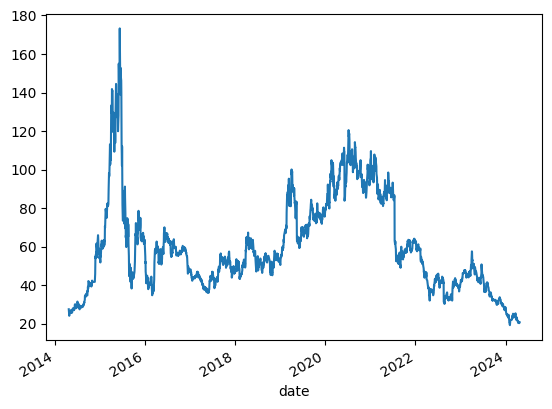

In [4]:
df.plot()

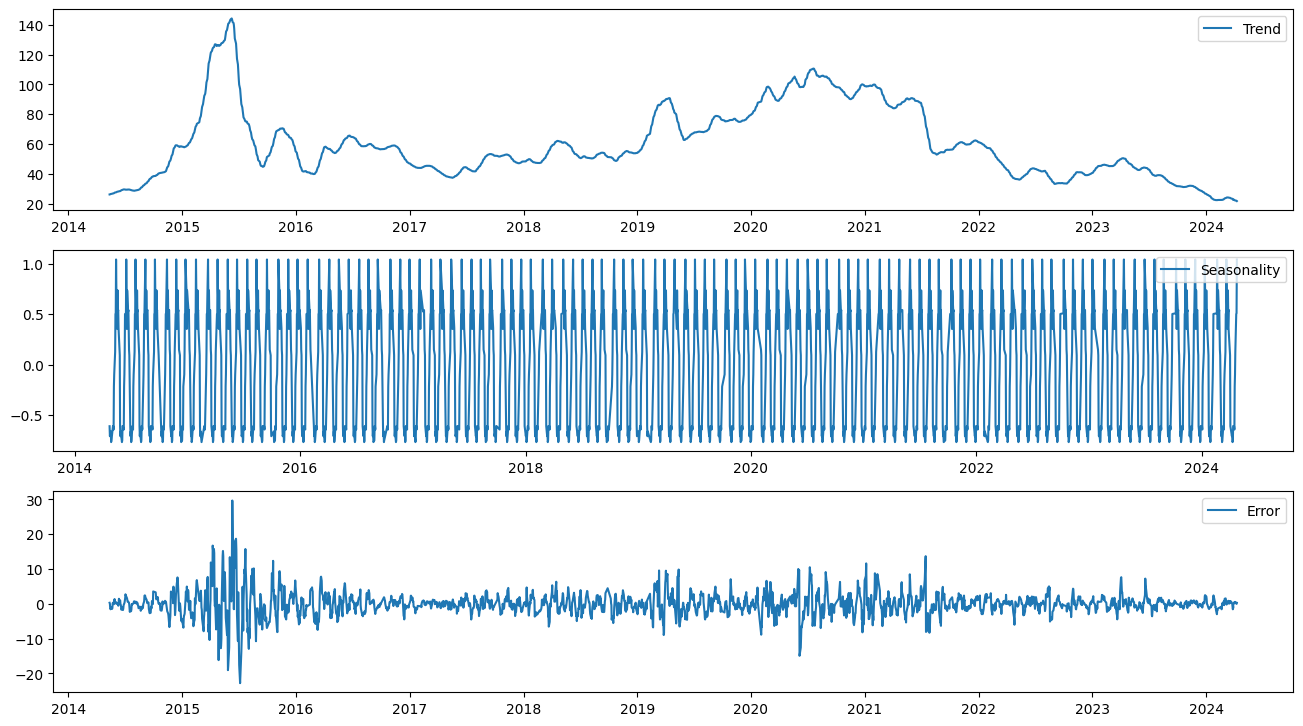

,trend_component
date,
2014-05-13,26.280682
2014-05-14,26.313409
2014-05-15,26.423409
2014-05-16,26.558636
2014-05-19,26.657273
...,...
2024-04-01,22.646591
2024-04-02,22.470227
2024-04-03,22.271591


In [5]:
def decomposing(time_series):
    decompostition = seasonal_decompose(time_series, model='additive', period=22)
    trend =  decompostition.trend
    seasonal = decompostition.seasonal
    random = decompostition.resid
    
    plt.figure(figsize=(16,12))
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc = 'best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc = 'best')
    plt.subplot(414)
    plt.plot(random, label='Error')
    plt.legend(loc = 'best')
    plt.show()
    return trend,seasonal,random

def to_frame(data):
    df = pd.DataFrame(data)
    df = df.dropna()
    df.columns = ['{}_component'.format(data.name)]
    return df

trendComponent,seasonalComponent,randomComponent = decomposing(df)
randomComponent = to_frame(randomComponent)
seasonalComponent = to_frame(seasonalComponent)
trendComponent = to_frame(trendComponent)
trendComponent

In [6]:
def adf_test(prices):
    result = adfuller(prices, autolag='AIC', regression='ctt')  # 趋势+截距 #如果时间序列图显示数据随时间明显上升或下降
    print('ADF Statistic for trend and intercept: %f' % result[0])
    print('p-value for trend and intercept: %f' % result[1])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")

    result = adfuller(prices, autolag='AIC', regression='ct')  # 趋势+截距 #如果时间序列图显示数据随时间明显上升或下降
    print('ADF Statistic for trend and intercept: %f' % result[0])
    print('p-value for trend and intercept: %f' % result[1])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")
    
    result = adfuller(prices, autolag='AIC', regression='c')  # 截距 #如果数据看似围绕一个固定均值波动
    print('ADF Statistic for intercept: %f' % result[0])
    print('p-value for intercept: %f' % result[1])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)    
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")
    
    result = adfuller(prices, autolag='AIC', regression='n')  # 无趋势无截距
    print('ADF Statistic for none: %f' % result[0])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)
    print('p-value for none: %f' % result[1])
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")

adf_test(df)

ADF Statistic for trend and intercept: -2.944766
p-value for trend and intercept: 0.322162
Critical Values:
	 1% : -4.375920687845923
	 5% : -3.8348304942440863
	 10% : -3.554771889438058
This implies that the time series is non-stationary.
ADF Statistic for trend and intercept: -2.693044
p-value for trend and intercept: 0.238982
Critical Values:
	 1% : -3.962512716877251
	 5% : -3.4123042603368963
	 10% : -3.1281182181571725
This implies that the time series is non-stationary.
ADF Statistic for intercept: -2.541679
p-value for intercept: 0.105660
Critical Values:
	 1% : -3.4330528258368695
	 5% : -2.862734077195586
	 10% : -2.5674056563936007
This implies that the time series is non-stationary.
ADF Statistic for none: -0.990099
Critical Values:
	 1% : -2.566663739687328
	 5% : -1.9411114715214763
	 10% : -1.616710799437523
p-value for none: 0.292082
This implies that the time series is non-stationary.


In [7]:
dftest = adfuller(df, autolag = 'AIC')
print("1. ADF:", dftest[0])
print("2. P-Value:", dftest[1])
print("3. Num of Lags:", dftest[2])
print("4. Num of Observations Used For ADF Regression and Critical Values Calculation:", dftest[3])
print("5. Critical Values:")
for key, val in dftest[4].items():
    print("\t", key, ":", val)

if dftest[1] > 0.05:
    print("This implies that the time series is non-stationary.")
else:
    print("This implies that the time series is stationary.")

1. ADF: -2.541679433954767
2. P-Value: 0.10565972491649761
3. Num of Lags: 11
4. Num of Observations Used For ADF Regression and Critical Values Calculation: 2422
5. Critical Values:
	 1% : -3.4330528258368695
	 5% : -2.862734077195586
	 10% : -2.5674056563936007
This implies that the time series is non-stationary.


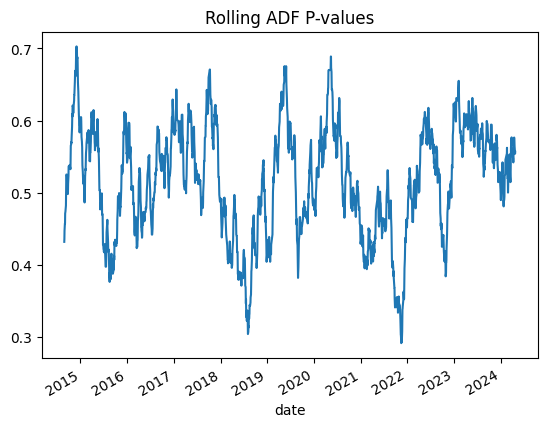

In [8]:
def rolling_adf(series, window):
    adf_results = series.rolling(window=22).apply(lambda x: adfuller(x)[1], raw=False).rolling(window=window).mean()
    return adf_results

rolling_adf_results = rolling_adf(df, 66)
rolling_adf_results.plot(title="Rolling ADF P-values")
plt.show()

## 建模

In [25]:
df = qtd.read("close", code='600570.XSHG', start="20140424", stop="20240424").droplevel(0)    #恒生电子
df2 = df['close'].diff()
df = df['close']
df2 = df2.dropna()
df2

date
2014-04-25   -0.710001
2014-04-28   -2.680000
2014-04-29    0.500000
2014-04-30    0.900000
2014-05-05    1.080000
                ...   
2024-04-18   -0.040001
2024-04-19   -0.680000
2024-04-22    0.260000
2024-04-23   -0.020000
2024-04-24    0.230001
Name: close, Length: 2433, dtype: float32

In [27]:
def adf_test(prices):
    result = adfuller(prices, autolag='AIC', regression='ctt')  # 趋势+截距 #如果时间序列图显示数据随时间明显上升或下降
    print('ADF Statistic for trend and intercept: %f' % result[0])
    print('p-value for trend and intercept: %f' % result[1])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")

    result = adfuller(prices, autolag='AIC', regression='ct')  # 趋势+截距 #如果时间序列图显示数据随时间明显上升或下降
    print('ADF Statistic for trend and intercept: %f' % result[0])
    print('p-value for trend and intercept: %f' % result[1])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")
    
    result = adfuller(prices, autolag='AIC', regression='c')  # 截距 #如果数据看似围绕一个固定均值波动
    print('ADF Statistic for intercept: %f' % result[0])
    print('p-value for intercept: %f' % result[1])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)    
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")
    
    result = adfuller(prices, autolag='AIC', regression='n')  # 无趋势无截距
    print('ADF Statistic for none: %f' % result[0])
    print("Critical Values:")
    for key, val in result[4].items():
        print("\t", key, ":", val)
    print('p-value for none: %f' % result[1])
    if result[1] > 0.05:
        print("This implies that the time series is non-stationary.")
    else:
        print("This implies that the time series is stationary.")

adf_test(df2)

ADF Statistic for trend and intercept: -14.925373
p-value for trend and intercept: 0.000000
Critical Values:
	 1% : -4.375920687845923
	 5% : -3.8348304942440863
	 10% : -3.554771889438058
This implies that the time series is stationary.
ADF Statistic for trend and intercept: -14.928097
p-value for trend and intercept: 0.000000
Critical Values:
	 1% : -3.962512716877251
	 5% : -3.4123042603368963
	 10% : -3.1281182181571725
This implies that the time series is stationary.
ADF Statistic for intercept: -14.894965
p-value for intercept: 0.000000
Critical Values:
	 1% : -3.4330528258368695
	 5% : -2.862734077195586
	 10% : -2.5674056563936007
This implies that the time series is stationary.
ADF Statistic for none: -14.897970
Critical Values:
	 1% : -2.566663739687328
	 5% : -1.9411114715214763
	 10% : -1.616710799437523
p-value for none: 0.000000
This implies that the time series is stationary.


In [28]:
dftest = adfuller(df2, autolag = 'AIC')
print("1. ADF:", dftest[0])
print("2. P-Value:", dftest[1])
print("3. Num of Lags:", dftest[2])
print("4. Num of Observations Used For ADF Regression and Critical Values Calculation:", dftest[3])
print("5. Critical Values:")
for key, val in dftest[4].items():
    print("\t", key, ":", val)

if dftest[1] > 0.05:
    print("This implies that the time series is non-stationary.")
else:
    print("This implies that the time series is stationary.")

1. ADF: -14.894964689017941
2. P-Value: 1.5372417802635067e-27
3. Num of Lags: 10
4. Num of Observations Used For ADF Regression and Critical Values Calculation: 2422
5. Critical Values:
	 1% : -3.4330528258368695
	 5% : -2.862734077195586
	 10% : -2.5674056563936007
This implies that the time series is stationary.


<Figure size 1400x700 with 0 Axes>

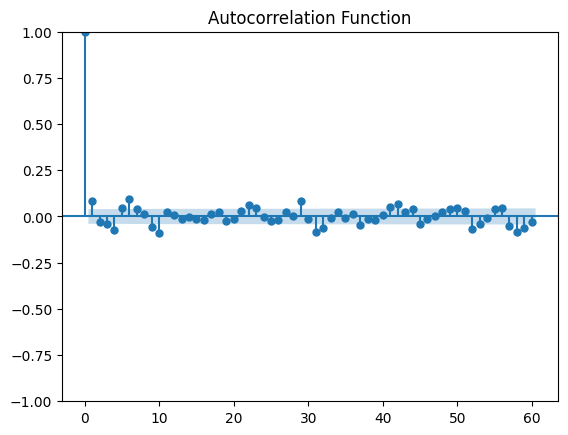

<Figure size 1400x700 with 0 Axes>

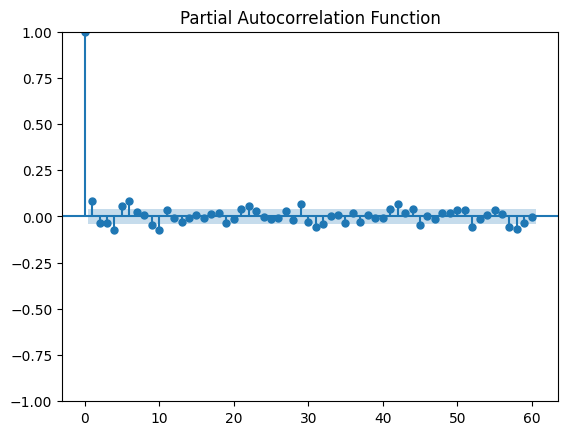

In [95]:
# Sample ACF
plt.figure(figsize=(14, 7))
plot_acf(df2, lags=60, alpha=0.05) 
plt.title('Autocorrelation Function')
plt.show()

# Sample PACF
plt.figure(figsize=(14, 7))
plot_pacf(df2, lags=60, alpha=0.05) 
plt.title('Partial Autocorrelation Function')
plt.show()

# p - 自回归项的阶数，可以从 PACF 图中找到显著的滞后数。
# d - 差分次数，使得数据成为平稳序列。
# q - 移动平均项的阶数，可以从 ACF 图中找到显著的滞后数。

/home/wiikai/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wiikai/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wiikai/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wiikai/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wiik

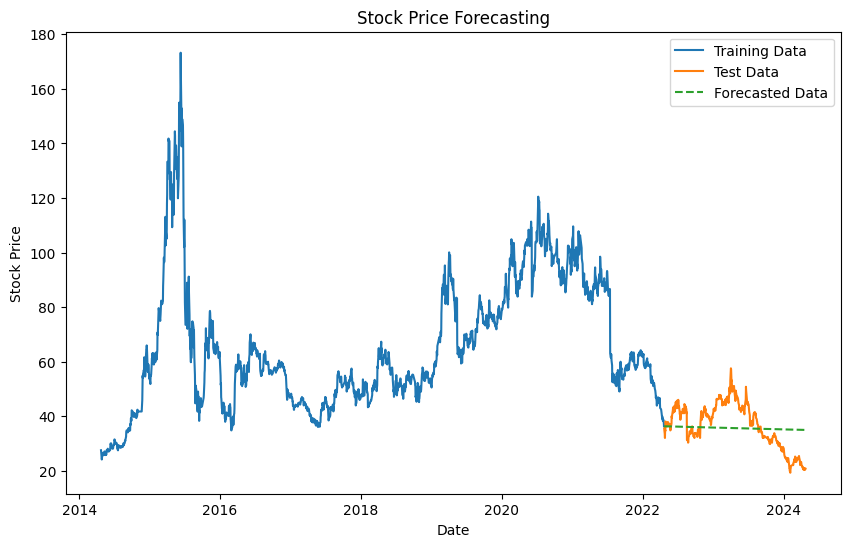

In [102]:
n = len(df)
train_data = df[:int(n*0.8)]
test_data = df[int(n*0.8):]

model = ARIMA(df2, order=(1, 0, 1)) 
model_fit = model.fit()

diff_forecast = model_fit.forecast(steps=len(test_data))

# 将差分预测结果转换为原始数据
last_train_value = train_data.iloc[-1]
original_forecast = last_train_value + diff_forecast.cumsum()

# 使用测试集的日期索引来标记预测结果
forecast_series = pd.Series(data=original_forecast.values, index=test_data.index)

plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(forecast_series, label='Forecasted Data', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Forecasting')
plt.show()

In [109]:
# n = len(df)
# train = df[:int(n*0.8)]
# test = df[int(n*0.8):]

# model = ARIMA(train, order=(2, 2, 22))  #p,d,q
# fitted_model = model.fit()

# forecast = fitted_model.get_forecast(steps=len(test))
# mean_forecast = forecast.predicted_mean
# conf_int = forecast.conf_int()

# plt.figure(figsize=(10, 5))
# plt.plot(df.index, df, label='Observed', color='blue')
# plt.plot(test.index, mean_forecast, label='Forecast', color='red')
# plt.title('ARIMA Forecast')
# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.legend()
# plt.show()

## 分钟线分析

In [111]:
df3 = qtm.read("close", code='600570.XSHG', start="20240101", stop="20240424").droplevel(0)  
df3 = df3['close']
df3

datetime
2024-01-02 09:31:00    28.809999
2024-01-02 09:32:00    28.809999
2024-01-02 09:33:00    28.799999
2024-01-02 09:34:00    28.590000
2024-01-02 09:35:00    28.590000
                         ...    
2024-04-23 14:56:00    20.540001
2024-04-23 14:57:00    20.540001
2024-04-23 14:58:00    20.540001
2024-04-23 14:59:00    20.540001
2024-04-23 15:00:00    20.549999
Name: close, Length: 17520, dtype: float32

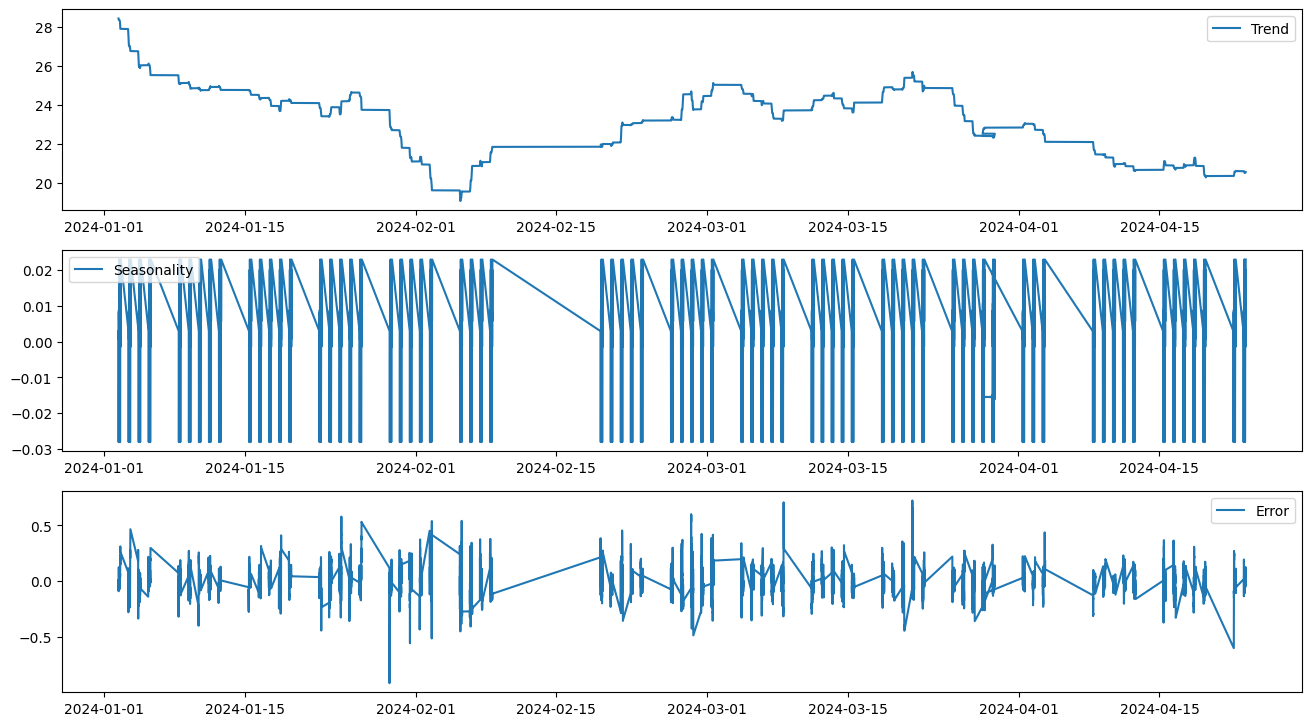

,trend_component
datetime,
2024-01-02 10:31:00,28.424042
2024-01-02 10:32:00,28.420042
2024-01-02 10:33:00,28.416292
2024-01-02 10:34:00,28.413417
2024-01-02 10:35:00,28.411583
...,...
2024-04-23 13:56:00,20.547208
2024-04-23 13:57:00,20.547792
2024-04-23 13:58:00,20.548292


In [114]:
def decomposing(time_series):
    decompostition = seasonal_decompose(time_series, model='additive', period=120)
    trend =  decompostition.trend
    seasonal = decompostition.seasonal
    random = decompostition.resid
    
    plt.figure(figsize=(16,12))
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc = 'best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc = 'best')
    plt.subplot(414)
    plt.plot(random, label='Error')
    plt.legend(loc = 'best')
    plt.show()
    return trend,seasonal,random

def to_frame(data):
    df = pd.DataFrame(data)
    df = df.dropna()
    df.columns = ['{}_component'.format(data.name)]
    return df

trendComponent,seasonalComponent,randomComponent = decomposing(df3)
randomComponent = to_frame(randomComponent)
seasonalComponent = to_frame(seasonalComponent)
trendComponent = to_frame(trendComponent)
trendComponent

In [117]:
adf_test(df3)

ADF Statistic for trend and intercept: -2.428719
p-value for trend and intercept: 0.609753
Critical Values:
	 1% : -4.371791694794424
	 5% : -3.832727201041783
	 10% : -3.553468946242751
This implies that the time series is non-stationary.
ADF Statistic for trend and intercept: -2.460949
p-value for trend and intercept: 0.347753
Critical Values:
	 1% : -3.9592869401353354
	 5% : -3.410740680293394
	 10% : -3.1271976264075008
This implies that the time series is non-stationary.
ADF Statistic for intercept: -2.572710
p-value for intercept: 0.098770
Critical Values:
	 1% : -3.4307233876788485
	 5% : -2.8617050229420165
	 10% : -2.5668578374267907
This implies that the time series is non-stationary.
ADF Statistic for none: -1.779425
Critical Values:
	 1% : -2.5658676551191952
	 5% : -1.9410153455131482
	 10% : -1.616804845561851
p-value for none: 0.071422
This implies that the time series is non-stationary.


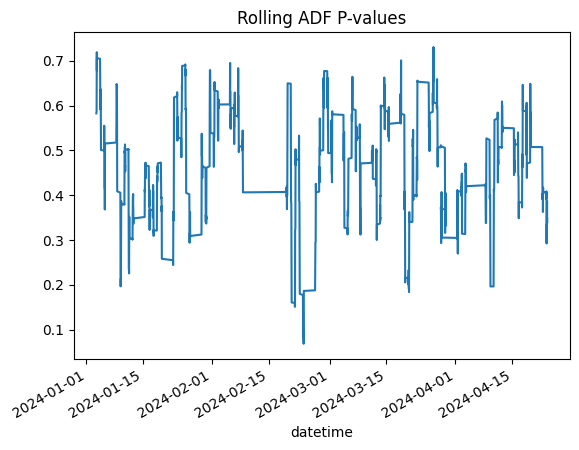

In [116]:
def rolling_adf(series, window):
    adf_results = series.rolling(window=120).apply(lambda x: adfuller(x)[1], raw=False).rolling(window=window).mean()
    return adf_results

rolling_adf_results = rolling_adf(df3, 240)
rolling_adf_results.plot(title="Rolling ADF P-values")
plt.show()